# Create media designs using ART

We use ART to provide suggested designs for media components for which to get phenotypic data.  We will use absorbance at 340nm as assay for this experiment.

For DBTL 8 we create X designs from an exploratory mode with $\alpha=1.$ and relative recommendations distance X%, X designs from the exploitation mode ($\alpha=0$) and relative recommendations distance X%, and 1 design being close to the standard media as a control, totalling 16 designs in triplicates.


Tested using **ART Prod** kernel on skynet.ese.lbl.gov

## Inputs and output

**Required file to run this notebook:**
- `Putida_media_bounds_extended.csv`
- `standard_recipe_concentrations_extended.csv`
- EDD study slug(s)

**File generated by running this notebook**
- 
-
-

The files are stored in the user defined directory. 

## Setup

Clone the git repository with the `ART` library 

`git clone https://github.com/JBEI/AutomatedRecommendationTool.git`  
<!-- <font color='red'> _____ -->
<!-- **WE SHOULD TALK ABOUT LICENSING HERE!!!** </font> -->

or pull the latest version. 

Information about licensing ART is available at https://github.com/JBEI/ART.

Importing needed libraries:

In [107]:
import os
import sys
import re
import warnings
import pickle
 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path




Import ART

In [108]:
sys.path.append('../')        # Make sure this is the location for the ART library 
sys.path.append('../media_compiler')

from art.core import RecommendationEngine 
import art.plot as plot
import art.utility as utils
import edd_utils as eddu
from core import designs_pairwise
import warning_utils
warning_utils.filter_end_user_warnings()



## User parameters

In [109]:
CYCLE = 5

user_params = {
    'bounds_file': f'../flaviolin yield data/Putida_media_bounds_yield.csv',
    'output_dir': f'../flaviolin yield data/DBTL{CYCLE}', # Folder for output files,
    'standard_media_file': '../flaviolin yield data/standard_recipe_concentrations.csv', #location of the standard media recipe
    'study_slug_1': 'combinatorial-media-optimization-for-flavioli-8a70', #DBTL1
    'study_slug_2': 'combinatorial-media-optimization-for-flaviolin-yie',#DBTL2
    'study_slug_3': 'combinatorial-media-optimization-for-flavioli-571b',#DBTL3
    'study_slug_4': 'combinatorial-media-optimization-for-flavioli-ca3a',#DBTL4
    'edd_server': 'edd.jbei.org',
    'username': 'azournas',
}

In [110]:
os.makedirs(user_params['output_dir'], exist_ok=True) #make the directory to store the output files

### Defining media components and the number of instances (designs) to be created

Specify which components to explore:

In [111]:
user_params['components'] = [
    'H3BO3[mM]',
    'Glucose[mM]',
    'K2SO4[mM]',
    'K2HPO4[mM]',
    'FeSO4[mM]',
    'NH4Cl[mM]',
    'MgCl2[mM]',
    'NaCl[mM]',
    '(NH4)6Mo7O24[mM]',
    'CoCl2[mM]',
    'CuSO4[mM]',
    'MnSO4[mM]',
    'ZnSO4[mM]',
    # 'CaCl2[mM]'    
]

user_params['response'] = 'OD340yield' #this will be the parameter we will maximize

Here we specify how many instances (designs) we want to create and how many replicates:

In [112]:
user_params['n_instances_explor'] = 3 # number of exploration recommendations
user_params['n_instances_exploit'] = 12 # number of exploitation recommendations
user_params['n_replicates'] = 3 # number of replicates generated in the biolector plate.
user_params['seed'] = 42
#The biolector plate we are using here is a 48-well plate. For 3 replicates, the total number of conditions tested will need to be 48/3 = 16. In this case 13 exploitation, 2 exploration and 1 standard. 

Lastly we specify the exploration and exploitation parameters (alpha) and the number of iterations that Parallel tempering will go through

In [113]:
user_params['alpha_explore'] = 1
user_params['alpha_exploit'] = 0 
user_params['n_iter'] = 1e5

In [114]:
user_params['scale_input_vars'] = False
user_params['cross_val'] = True
user_params['recommend'] = False

## Load the data

In [115]:
df_stand = pd.read_csv(user_params['standard_media_file']).set_index("Component")

In [116]:
study_slug_1 = user_params['study_slug_1']
study_slug_2 = user_params['study_slug_2']
study_slug_3 = user_params['study_slug_3']
study_slug_4 = user_params['study_slug_4']


edd_server = user_params['edd_server']
username = user_params['username']

In [117]:
try:
    session = eddu.login(edd_server=edd_server, user=username)
except:
    print('ERROR! Connection to EDD failed. We will try to load data from disk...')
    load_from_disk = True
else:
    print('OK! Connection to EDD successful. We will try to load data from EDD...')    
    load_from_disk = False

OK! Connection to EDD successful. We will try to load data from EDD...


In [118]:
try:
    df_1 = eddu.export_study(session, study_slug_1, edd_server=edd_server)
    df_2 = eddu.export_study(session, study_slug_2, edd_server=edd_server)
    df_3 = eddu.export_study(session, study_slug_3, edd_server=edd_server)
    df_4 = eddu.export_study(session, study_slug_4, edd_server=edd_server)

    load_from_disk = False
except (NameError, AttributeError, KeyError):
    print(f'ERROR! Not able to export the study.')
    load_from_disk = True

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

In [119]:

if load_from_disk:
    df_1 = pd.read_csv('../flaviolin yield data/df_dbtl1-yield.csv')
    df_2 = pd.read_csv('../flaviolin yield data/df_dbtl2-yield.csv')
    df_3 = pd.read_csv('../flaviolin yield data/df_dbtl3-yield.csv')
    df_4 = pd.read_csv('../flaviolin yield data/df_dbtl4-yield.csv')

else:
    df_1.to_csv('../flaviolin yield data/df_dbtl1-yield.csv')
    df_2.to_csv('../flaviolin yield data/df_dbtl2-yield.csv')
    df_3.to_csv('../flaviolin yield data/df_dbtl3-yield.csv')
    df_4.to_csv('../flaviolin yield data/df_dbtl4-yield.csv')


## Preprocess the data

Concatenate the six studies:

In [120]:
df = pd.concat([df_1, df_2, df_3, df_4])

/usr/local/art/.venv/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 66.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/art/.venv/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 33.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/art/.venv/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 66.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/art/.venv/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 33.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


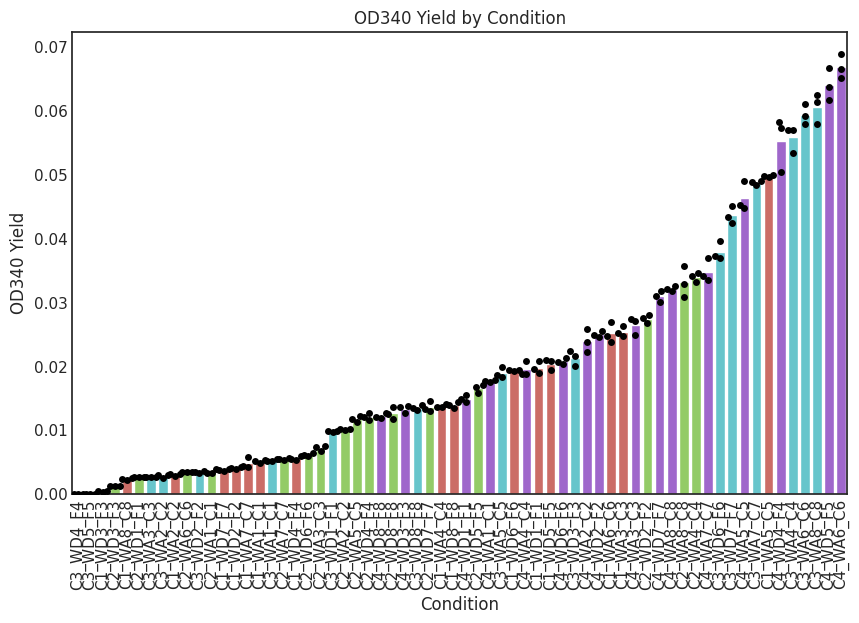

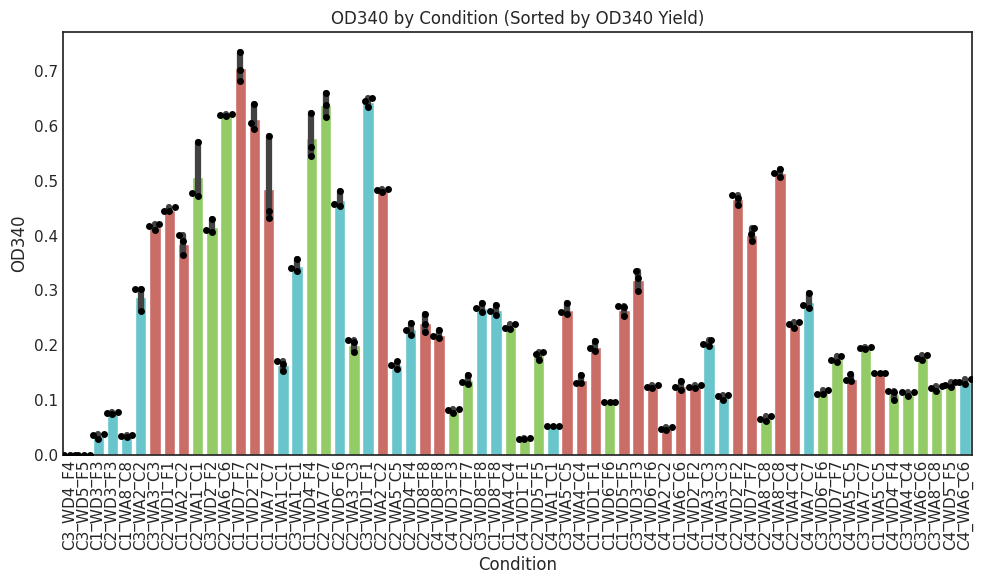

In [121]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your dataframe is named 'df'
# Create a new column 'condition' by extracting the first part of the line name
df['condition'] = df['Line Name'].str.rsplit('-', n=1).str[0]

# Create a new column 'X' by extracting the 'X' value from the line name
df['X'] = df['Line Name'].str.extract('C(\d+)_', expand=False)

# Extract the glucose concentration from the "Line Description" column
df['glucose_conc'] = df['Line Description'].str.extract('Glucose\[mM\]: (\d+)', expand=False).astype(float)

# Calculate OD340yield by dividing OD340 by glucose concentration
df['OD340yield'] = df['Value'] / df['glucose_conc']

# Group the data by 'condition' and calculate the mean of 'OD340yield'
grouped_data = df.groupby('condition')['OD340yield'].mean().reset_index()

# Sort the data by 'OD340yield' in ascending order
sorted_data = grouped_data.sort_values('OD340yield')

# Create a color palette based on 'X'
color_palette = sns.color_palette("hls", len(df['X'].unique()))
color_map = dict(zip(df['X'].unique(), color_palette))

# Create the first plot (OD340yield)
plt.figure(figsize=(10, 6))
ax1 = sns.barplot(x='condition', y='OD340yield', data=sorted_data, palette=[color_map[x] for x in sorted_data['condition'].str.extract('C(\d+)_', expand=False)])

# Sort the original dataframe based on the sorted conditions
sorted_conditions = sorted_data['condition'].tolist()
df_sorted = df.set_index('condition').loc[sorted_conditions].reset_index()

sns.swarmplot(x='condition', y='OD340yield', data=df_sorted, color='black', size=5, ax=ax1)
plt.xticks(rotation=90, ha='center')
plt.xlabel('Condition')
plt.ylabel('OD340 Yield')
plt.title('OD340 Yield by Condition')

# Create the second plot (OD340)
plt.figure(figsize=(10, 6))
sorted_data_od340 = df.sort_values('OD340yield')
ax2 = sns.barplot(x='condition', y='Value', data=sorted_data_od340, palette=[color_map[x] for x in sorted_data_od340['X']])
sns.swarmplot(x='condition', y='Value', data=sorted_data_od340, color='black', size=5, ax=ax2)
plt.xticks(rotation=90, ha='center')
plt.xlabel('Condition')
plt.ylabel('OD340')
plt.title('OD340 by Condition (Sorted by OD340 Yield)')

plt.tight_layout()
plt.show()

In [122]:
df_1

,Study ID,Study Name,Line ID,Replicate Key,Line Name,Line Description,Protocol,Assay ID,Assay Name,Formal Type,Measurement Type,Compartment,Units,Value,Hours
0,208439,Combinatorial Media Optimization for Flaviolin...,208440,c7f6759c-abae-42f1-94e2-da344bdb1678,C1_WA1_C1-R1,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,208488,C1_WA1_C1-R1,NaN,OD340,0,NaN,0.1664,48.0
1,208439,Combinatorial Media Optimization for Flaviolin...,208441,5c50572c-baaa-4537-91f9-d0c19304dd71,C1_WA1_C1-R2,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,208489,C1_WA1_C1-R2,NaN,OD340,0,NaN,0.1707,48.0
2,208439,Combinatorial Media Optimization for Flaviolin...,208442,8e320b95-6038-4ce6-baee-df5506e1eda5,C1_WA1_C1-R3,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,208490,C1_WA1_C1-R3,NaN,OD340,0,NaN,0.1535,48.0
3,208439,Combinatorial Media Optimization for Flaviolin...,208443,dea4c0a6-77ec-4937-8541-289e4d2a534a,C1_WD1_F1-R1,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,208491,C1_WD1_F1-R1,NaN,OD340,0,NaN,0.1894,48.0
4,208439,Combinatorial Media Optimization for Flaviolin...,208444,d08877ac-7bf2-4152-adb0-a378d9fdb36a,C1_WD1_F1-R2,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,208492,C1_WD1_F1-R2,NaN,OD340,0,NaN,0.1954,48.0
5,208439,Combinatorial Media Optimization for Flaviolin...,208445,3dcb42cd-7e5f-4ac0-acfd-f77f4778fedf,C1_WD1_F1-R3,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,208493,C1_WD1_F1-R3,NaN,OD340,0,NaN,0.2078,48.0
6,208439,Combinatorial Media Optimization for Flaviolin...,208446,2aa1e2fa-908a-4e99-9469-30ffe4e3c7b1,C1_WA2_C2-R1,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,208494,C1_WA2_C2-R1,NaN,OD340,0,NaN,0.3910,48.0
7,208439,Combinatorial Media Optimization for Flaviolin...,208447,c1e28672-28b9-4cd1-b57a-9e52f16f1b90,C1_WA2_C2-R2,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,208495,C1_WA2_C2-R2,NaN,OD340,0,NaN,0.4007,48.0
8,208439,Combinatorial Media Optimization for Flaviolin...,208448,e35d278d-177d-48fd-871c-0cb945b5156f,C1_WA2_C2-R3,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,208496,C1_WA2_C2-R3,NaN,OD340,0,NaN,0.3649,48.0
9,208439,Combinatorial Media Optimization for Flaviolin...,208449,45b7d58c-6efc-4cf2-9e5f-fcd1dd7a6ea0,C1_WD2_F2-R1,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,208497,C1_WD2_F2-R1,NaN,OD340,0,NaN,0.6051,48.0


In [123]:
df_2

,Study ID,Study Name,Line ID,Replicate Key,Line Name,Line Description,Protocol,Assay ID,Assay Name,Formal Type,Measurement Type,Compartment,Units,Value,Hours
0,208342,Combinatorial Media Optimization for Flaviolin...,208343,2333e82e-d052-4bc2-9ba3-dc478ab73cf8,C2_WA1_C1-R1,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,208391,C2_WA1_C1-R1,NaN,OD340,0,NaN,0.5700,48.0
1,208342,Combinatorial Media Optimization for Flaviolin...,208344,27133779-15eb-4f9a-8774-578f89c28191,C2_WA1_C1-R2,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,208392,C2_WA1_C1-R2,NaN,OD340,0,NaN,0.4714,48.0
2,208342,Combinatorial Media Optimization for Flaviolin...,208345,0ec14aee-e5cb-46a4-a6ff-b21369acde8f,C2_WA1_C1-R3,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,208393,C2_WA1_C1-R3,NaN,OD340,0,NaN,0.4779,48.0
3,208342,Combinatorial Media Optimization for Flaviolin...,208346,89e380d5-3b40-4840-8e61-2d2f2dd5a268,C2_WD1_F1-R1,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,208394,C2_WD1_F1-R1,NaN,OD340,0,NaN,0.4441,48.0
4,208342,Combinatorial Media Optimization for Flaviolin...,208347,01df708b-6438-43a6-9607-daec711598b2,C2_WD1_F1-R2,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,208395,C2_WD1_F1-R2,NaN,OD340,0,NaN,0.4453,48.0
5,208342,Combinatorial Media Optimization for Flaviolin...,208348,d941696c-e152-4606-82d7-86d94070bb5b,C2_WD1_F1-R3,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,208396,C2_WD1_F1-R3,NaN,OD340,0,NaN,0.4514,48.0
6,208342,Combinatorial Media Optimization for Flaviolin...,208349,128eadc9-ec8e-45be-a534-bca0b21a2028,C2_WA2_C2-R1,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,208397,C2_WA2_C2-R1,NaN,OD340,0,NaN,0.4791,48.0
7,208342,Combinatorial Media Optimization for Flaviolin...,208350,f1d6fc00-61ec-4f09-878d-d1e1cadced10,C2_WA2_C2-R2,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,208398,C2_WA2_C2-R2,NaN,OD340,0,NaN,0.4845,48.0
8,208342,Combinatorial Media Optimization for Flaviolin...,208351,277df07a-9238-4344-ba55-923dfcfde665,C2_WA2_C2-R3,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,208399,C2_WA2_C2-R3,NaN,OD340,0,NaN,0.4835,48.0
9,208342,Combinatorial Media Optimization for Flaviolin...,208352,24d3cabb-1488-4f75-acc9-ee1cf829eee5,C2_WD2_F2-R1,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,208400,C2_WD2_F2-R1,NaN,OD340,0,NaN,0.4555,48.0


In [126]:
df.head()

,Study ID,Study Name,Line ID,Replicate Key,Line Name,Line Description,Protocol,Assay ID,Assay Name,Formal Type,Measurement Type,Compartment,Units,Value,Hours,condition,X,glucose_conc,OD340yield
0,208439,Combinatorial Media Optimization for Flaviolin...,208440,c7f6759c-abae-42f1-94e2-da344bdb1678,C1_WA1_C1-R1,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,208488,C1_WA1_C1-R1,NaN,OD340,0,NaN,0.1664,48.0,C1_WA1_C1,1,32.0,0.005200
1,208439,Combinatorial Media Optimization for Flaviolin...,208441,5c50572c-baaa-4537-91f9-d0c19304dd71,C1_WA1_C1-R2,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,208489,C1_WA1_C1-R2,NaN,OD340,0,NaN,0.1707,48.0,C1_WA1_C1,1,32.0,0.005334
2,208439,Combinatorial Media Optimization for Flaviolin...,208442,8e320b95-6038-4ce6-baee-df5506e1eda5,C1_WA1_C1-R3,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,208490,C1_WA1_C1-R3,NaN,OD340,0,NaN,0.1535,48.0,C1_WA1_C1,1,32.0,0.004797
3,208439,Combinatorial Media Optimization for Flaviolin...,208443,dea4c0a6-77ec-4937-8541-289e4d2a534a,C1_WD1_F1-R1,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,208491,C1_WD1_F1-R1,NaN,OD340,0,NaN,0.1894,48.0,C1_WD1_F1,1,10.0,0.018940
4,208439,Combinatorial Media Optimization for Flaviolin...,208444,d08877ac-7bf2-4152-adb0-a378d9fdb36a,C1_WD1_F1-R2,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,208492,C1_WD1_F1-R2,NaN,OD340,0,NaN,0.1954,48.0,C1_WD1_F1,1,10.0,0.019540


### clean up the df

In [129]:
df.head()

,Study ID,Study Name,Line ID,Replicate Key,Line Name,Line Description,Protocol,Assay ID,Assay Name,Formal Type,Measurement Type,Compartment,Units,Value,Hours,condition,X,glucose_conc,OD340yield
0,208439,Combinatorial Media Optimization for Flaviolin...,208440,c7f6759c-abae-42f1-94e2-da344bdb1678,C1_WA1_C1-R1,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,208488,C1_WA1_C1-R1,NaN,OD340,0,NaN,0.1664,48.0,C1_WA1_C1,1,32.0,0.005200
1,208439,Combinatorial Media Optimization for Flaviolin...,208441,5c50572c-baaa-4537-91f9-d0c19304dd71,C1_WA1_C1-R2,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,208489,C1_WA1_C1-R2,NaN,OD340,0,NaN,0.1707,48.0,C1_WA1_C1,1,32.0,0.005334
2,208439,Combinatorial Media Optimization for Flaviolin...,208442,8e320b95-6038-4ce6-baee-df5506e1eda5,C1_WA1_C1-R3,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,208490,C1_WA1_C1-R3,NaN,OD340,0,NaN,0.1535,48.0,C1_WA1_C1,1,32.0,0.004797
3,208439,Combinatorial Media Optimization for Flaviolin...,208443,dea4c0a6-77ec-4937-8541-289e4d2a534a,C1_WD1_F1-R1,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,208491,C1_WD1_F1-R1,NaN,OD340,0,NaN,0.1894,48.0,C1_WD1_F1,1,10.0,0.018940
4,208439,Combinatorial Media Optimization for Flaviolin...,208444,d08877ac-7bf2-4152-adb0-a378d9fdb36a,C1_WD1_F1-R2,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,208492,C1_WD1_F1-R2,NaN,OD340,0,NaN,0.1954,48.0,C1_WD1_F1,1,10.0,0.019540


In [130]:
df.tail()

,Study ID,Study Name,Line ID,Replicate Key,Line Name,Line Description,Protocol,Assay ID,Assay Name,Formal Type,Measurement Type,Compartment,Units,Value,Hours,condition,X,glucose_conc,OD340yield
43,209871,Combinatorial Media Optimization for Flaviolin...,209915,7b92e291-dd46-42d6-9d28-c1b269402fce,C4_WA8_C8-R2,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,209963,C4_WA8_C8-R2,NaN,OD340,0,NaN,0.5215,48.0,C4_WA8_C8,4,16.0,0.032594
44,209871,Combinatorial Media Optimization for Flaviolin...,209916,7008d158-fb83-4882-b930-58eac58af9a2,C4_WA8_C8-R3,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,209964,C4_WA8_C8-R3,NaN,OD340,0,NaN,0.5066,48.0,C4_WA8_C8,4,16.0,0.031663
45,209871,Combinatorial Media Optimization for Flaviolin...,209917,67dea9b7-4452-4ea4-8b2a-fa943b970fd6,C4_WD8_F8-R1,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,209965,C4_WD8_F8-R1,NaN,OD340,0,NaN,0.2280,48.0,C4_WD8_F8,4,18.0,0.012667
46,209871,Combinatorial Media Optimization for Flaviolin...,209918,6d74462a-c186-4bc4-96ef-91849e4184a2,C4_WD8_F8-R2,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,209966,C4_WD8_F8-R2,NaN,OD340,0,NaN,0.2162,48.0,C4_WD8_F8,4,18.0,0.012011
47,209871,Combinatorial Media Optimization for Flaviolin...,209919,de6c6e13-5041-464c-a000-7934c40e2103,C4_WD8_F8-R3,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,209967,C4_WD8_F8-R3,NaN,OD340,0,NaN,0.2130,48.0,C4_WD8_F8,4,18.0,0.011833


Drop unnecessary columns:

In [131]:
df = df.loc[:,['Line Name','Line Description','Measurement Type','Value']]


Pivot the dataframe: This will generate a line for each sample with the corresponding OD600 and OD340 values

In [132]:
df = df.pivot(index=["Line Name", "Line Description"], columns="Measurement Type", values="Value")
df.reset_index(inplace=True)


Drop OD600 since we are not using it

### Adding media information to the data frame

Add columns for each component:

In [133]:
components = re.split(': |, ', df['Line Description'][0])[::2]
for comp in components:
    df[comp] = None
# df['CaCl2[mM]'] = 0 # add a column for CaCl2. 
#CaCl2 is only added to DBTL 7 and 8 so it doesn't exist in the line descriptions for DBTL 1-6. 
#Concentration of CaCl2 will be 0 for DBTL 1-6

#df['Kan[g/L]'] = None # add a column for Kan. 
#Kan concentration is 0.05 g/l. 
#This is the same concentration for all cases and is not used by ART.
#this is in the Line descriptions only for DBTL8



For every component in the line description assign the right value in each column created previously.

In [134]:
for i in range(len(df)):
    values = re.split(': |, ', df['Line Description'][i])[1::2]
    for c, value in enumerate(values):
        df.iloc[i, (3+c)] = float(value)


df.drop(columns='Line Description', inplace=True)


### Include Yield and clean up the training data

Include the Yield column:

In [135]:
df['OD340yield'] = df['OD340']/df['Glucose[mM]']
df['OD340yield']

0      0.005044
1      0.005174
2      0.004653
3      0.003015
4       0.00309
         ...   
187    0.031542
188    0.030688
189     0.01266
190    0.012005
191    0.011827
Name: OD340yield, Length: 192, dtype: object

In [136]:
# df.iloc[df['OD340'].idxmax(),:]
# df['OD340'].idxmax()
# df = df[df['OD340'] < .86]

# outliers = ['C2.1_WA7_B1-R1','C2.1_WB8_C2-R1']

# df = df[~df['Line Name'].isin(outliers)]

In [137]:
df.head()

Measurement Type,Line Name,OD340,MOPS[mM],Tricine[mM],H3BO3[mM],Glucose[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],Kan[g/l],OD340yield
0,C1_WA1_C1-R1,0.1664,40.0,4.0,0.003661,32.989243,0.144954,0.61429,0.01745,7.979403,0.270786,26.240883,0.000021,0.000706,0.000188,0.000546,0.000092,0.05,0.005044
1,C1_WA1_C1-R2,0.1707,40.0,4.0,0.003661,32.989243,0.144954,0.61429,0.01745,7.979403,0.270786,26.240883,0.000021,0.000706,0.000188,0.000546,0.000092,0.05,0.005174
2,C1_WA1_C1-R3,0.1535,40.0,4.0,0.003661,32.989243,0.144954,0.61429,0.01745,7.979403,0.270786,26.240883,0.000021,0.000706,0.000188,0.000546,0.000092,0.05,0.004653
3,C1_WA2_C2-R1,0.3910,40.0,4.0,0.001096,129.69516,0.215986,5.430301,0.070543,9.628863,0.396082,21.94981,0.000185,0.000054,0.000027,0.000771,0.000028,0.05,0.003015
4,C1_WA2_C2-R2,0.4007,40.0,4.0,0.001096,129.69516,0.215986,5.430301,0.070543,9.628863,0.396082,21.94981,0.000185,0.000054,0.000027,0.000771,0.000028,0.05,0.00309


In [138]:
df.tail()

Measurement Type,Line Name,OD340,MOPS[mM],Tricine[mM],H3BO3[mM],Glucose[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],Kan[g/l],OD340yield
187,C4_WD7_F7-R2,0.4136,40.0,4.0,0.030974,13.112744,0.982282,2.220679,0.097841,7.25641,3.672026,461.816356,0.000114,0.000194,0.000544,0.005805,0.000759,0.05,0.031542
188,C4_WD7_F7-R3,0.4024,40.0,4.0,0.030974,13.112744,0.982282,2.220679,0.097841,7.25641,3.672026,461.816356,0.000114,0.000194,0.000544,0.005805,0.000759,0.05,0.030688
189,C4_WD8_F8-R1,0.2280,40.0,4.0,0.004383,18.009772,0.293764,1.437228,0.010266,8.593542,0.48597,46.323371,0.000028,0.000304,0.000102,0.00078,0.000098,0.05,0.01266
190,C4_WD8_F8-R2,0.2162,40.0,4.0,0.004383,18.009772,0.293764,1.437228,0.010266,8.593542,0.48597,46.323371,0.000028,0.000304,0.000102,0.00078,0.000098,0.05,0.012005
191,C4_WD8_F8-R3,0.2130,40.0,4.0,0.004383,18.009772,0.293764,1.437228,0.010266,8.593542,0.48597,46.323371,0.000028,0.000304,0.000102,0.00078,0.000098,0.05,0.011827


Remove all the low performing strains

bar plot the training data

Define the control lines. In DBTL 1 and 2, controls were wells F5 to F8. In other DBTL cycles the control is stored in the last column (D8, E8, F8).

In [139]:
control_lines = df[df['Line Name'].str.find('WF5_F8') > 0]

#control_lines = control_lines.append(df[df['Line Name'].str.find('WD8_F8') > 0])

control_lines = pd.concat([control_lines, df[df['Line Name'].str.find('WD8_F8') > 0]], ignore_index=True)

### Convert the data to EDD format

Pivot the dataframe back to EDD format, including all the components names and protocols:

In [140]:
df_stacked = df.set_index('Line Name').stack().reset_index()
df_stacked.columns = ['Line Name', 'Measurement Type', 'Value']
df_stacked

,Line Name,Measurement Type,Value
0,C1_WA1_C1-R1,OD340,0.1664
1,C1_WA1_C1-R1,MOPS[mM],40.0
2,C1_WA1_C1-R1,Tricine[mM],4.0
3,C1_WA1_C1-R1,H3BO3[mM],0.003661
4,C1_WA1_C1-R1,Glucose[mM],32.989243
...,...,...,...
3451,C4_WD8_F8-R3,CuSO4[mM],0.000102
3452,C4_WD8_F8-R3,MnSO4[mM],0.00078
3453,C4_WD8_F8-R3,ZnSO4[mM],0.000098
3454,C4_WD8_F8-R3,Kan[g/l],0.05


In [141]:
df_stacked = df.set_index('Line Name').stack().reset_index()
df_stacked.columns = ['Line Name', 'Measurement Type', 'Value']

### OD340 of the highest performing strains is at 0.7. 
### I multiply the data by 1000 to bring it up to ~700 to improve parallel tempering performance
# df_stacked.loc[df_stacked["Measurement Type"] == "OD340yield", 'Value'] = df_stacked.loc[df_stacked["Measurement Type"] == "OD340yield", 'Value'] 

df_stacked


,Line Name,Measurement Type,Value
0,C1_WA1_C1-R1,OD340,0.1664
1,C1_WA1_C1-R1,MOPS[mM],40.0
2,C1_WA1_C1-R1,Tricine[mM],4.0
3,C1_WA1_C1-R1,H3BO3[mM],0.003661
4,C1_WA1_C1-R1,Glucose[mM],32.989243
...,...,...,...
3451,C4_WD8_F8-R3,CuSO4[mM],0.000102
3452,C4_WD8_F8-R3,MnSO4[mM],0.00078
3453,C4_WD8_F8-R3,ZnSO4[mM],0.000098
3454,C4_WD8_F8-R3,Kan[g/l],0.05


## Define functions we will use to train art, generate recommendations and plot the results

In [144]:
def train_art(df, user_params,art_filename):
    art_params = {
    'input_vars': user_params['components'],
    'response_vars': [user_params['response']],
    'bounds': utils.read_table(user_params['bounds_file']), # file with bounds# input variables, i.e. features
    'scale_input_vars': user_params['scale_input_vars'],
    'cross_val': user_params['cross_val'],
    'cross_val_partitions': user_params['cross_val_partitions'],
    'recommend': user_params['recommend'],
    'output_dir': user_params['output_dir'],  # directory to store this output
    'verbose': 1,
    'num_tpot_models': 4,
    'max_mcmc_cores': 4,
    'seed': user_params['seed'],
    'build_model' : True,
    'recommend' : False
    }
    
    # art_params['bounds'] = art_params['bounds'].drop(index=[0,1,3])
    
    art = RecommendationEngine(df=df, **art_params)
    
    art.save()
    
    orig_file_name = f"{art_params['output_dir']}/art.cpkl"
    new_file_name = f"{art_params['output_dir']}/{art_filename}"
    os.rename(orig_file_name, new_file_name)

    return art

In [150]:
user_params['cross_val_partitions'] = 4

### Train ART

In [152]:
art = train_art(df_stacked, user_params, 'art_yield_DBTL4.cpkl')
# import cloudpickle

# with open(user_params['output_dir']+'/art_yield_DBTL4.cpkl', "rb") as f:
#     art = cloudpickle.load(f)


In [98]:
# art.recommendations = pd.read_csv('../flaviolin data/DBTL3/recommendations_x100.csv')[user_params['components']]
# art.recommendations

### Define the function we need to generate recommendations using differential evolution

In [99]:
from scipy.optimize import differential_evolution, Bounds
def recommend_DE(art, user_params):
    def obj_func(x, art, draws):
        #print(x.shape)
        foo = art.post_pred_stats(x)
        #file1.write(str(x.flatten()[1:-1]))
        G = np.squeeze((1-art.alpha)*foo[0] +  art.alpha*foo[1])
        draws.append(np.append(x,G))

        return -G

    f = lambda x: obj_func(x,art, draws)
    draws = []
    result = differential_evolution(f, Bounds(art.bounds.values[:,0], art.bounds.values[:,1]), \
                                    maxiter = user_params['maxiter'], popsize= user_params['popsize'], vectorized = False,
                                    strategy = 'rand2exp', mutation =user_params['mutation'], recombination=user_params['recombination'], updating='deferred')

    draws = np.array(draws) #make into a numpy array
    draws_padded = np.hstack((draws, np.reshape(draws[:,-1], [-1,1]))) # add an extra column in the end to achieve n_input_vars+2

    from art.core.recommender import Recommender

    recommender = Recommender(
                art.loader,
                art.create_bounds(),
                art._args,
                publish_recs=False,
                # ### Pass-through RE params  #######
                # self.input_vars,
                # self.num_recommendations,
                # self.output_dir,
                # self.rel_rec_distance,
                # self.response_vars,
                # self.testing,
                # self.verbose,
                # self.warning_callback,
            )
    recommendations = recommender.select(draws_padded)
    return recommendations, draws

In [100]:
user_params['maxiter'] = 4
user_params['popsize'] = 1000
user_params['mutation'] = (1,1.9)
user_params['recombination'] = 0.5
art.rel_rec_distance = 3

In [101]:
user_params

{'bounds_file': '../flaviolin yield data/Putida_media_bounds_yield.csv',
 'output_dir': '../flaviolin yield data/DBTL5',
 'standard_media_file': '../flaviolin yield data/standard_recipe_concentrations.csv',
 'study_slug_1': 'combinatorial-media-optimization-for-flavioli-8a70',
 'study_slug_2': 'combinatorial-media-optimization-for-flaviolin-yie',
 'study_slug_3': 'combinatorial-media-optimization-for-flavioli-571b',
 'study_slug_4': 'combinatorial-media-optimization-for-flavioli-ca3a',
 'edd_server': 'edd.jbei.org',
 'username': 'azournas',
 'components': ['H3BO3[mM]',
  'Glucose[mM]',
  'K2SO4[mM]',
  'K2HPO4[mM]',
  'FeSO4[mM]',
  'NH4Cl[mM]',
  'MgCl2[mM]',
  'NaCl[mM]',
  '(NH4)6Mo7O24[mM]',
  'CoCl2[mM]',
  'CuSO4[mM]',
  'MnSO4[mM]',
  'ZnSO4[mM]'],
 'response': 'OD340yield',
 'n_instances_explor': 3,
 'n_instances_exploit': 12,
 'n_replicates': 3,
 'seed': 42,
 'alpha_explore': 1,
 'alpha_exploit': 0,
 'n_iter': 100000.0,
 'scale_input_vars': False,
 'cross_val': True,
 'recomme

### Generate Exploration recommendations

In [102]:
art.alpha = user_params['alpha_explore']
art.num_recommendations = user_params['n_instances_explor']

df_recs_explore, draws_explore = recommend_DE(art, user_params)

Choosing recommendations (66,064 candidates)…


Done choosing recommendations in 12.38 s


### Generate Exploitation recommendations

In [103]:
art.alpha = user_params['alpha_exploit']
art.num_recommendations = user_params['n_instances_exploit']

df_recs_exploit, draws_exploit = recommend_DE(art, user_params)

Choosing recommendations (66,414 candidates)…


Done choosing recommendations in 209.39 s


In [104]:
df_recs_explore = df_recs_explore[art._args.input_vars]
df_recs_exploit = df_recs_exploit[art._args.input_vars]


mean_explore, std_explore = art.post_pred_stats(df_recs_explore[art._args.input_vars])
df_recs_explore['OD34yield_pred'] = mean_explore
df_recs_explore['OD34yield_std_pred'] = std_explore

mean_exploit, std_exploit = art.post_pred_stats(df_recs_exploit[art._args.input_vars])
df_recs_exploit['OD34yield_pred'] = mean_exploit
df_recs_exploit['OD34yield_std_pred'] = std_exploit


df_recs_explore['Label'] = 'explore'
df_recs_exploit['Label'] = 'exploit'


In [105]:
df_recs_explore

,H3BO3[mM],Glucose[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],OD34yield_pred,OD34yield_std_pred,Label
0,0.010297,27.059124,0.621127,1.750458,0.094576,8.031188,5.014839,413.334699,0.000267,0.001136,0.000882,0.007664,0.000813,0.020081,0.020081,explore
1,0.023602,42.134466,2.550924,2.664037,0.072290,11.481638,4.544464,487.017171,0.000237,0.001662,0.000872,0.003006,0.000808,0.016290,0.016290,explore
2,0.008966,193.805281,1.926112,5.748878,0.039737,9.838307,5.155804,5.173706,0.000049,0.002327,0.000928,0.005460,0.000817,0.003760,0.003760,explore


In [106]:
df_recs_exploit

,H3BO3[mM],Glucose[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],OD34yield_pred,OD34yield_std_pred,Label
0,0.036718,5.712798,1.470500,3.233307,0.082088,13.290065,5.085642,358.277655,0.000272,0.002599,0.000413,0.007636,0.000982,0.032795,0.032795,exploit
1,0.019906,21.398401,0.936599,0.705858,0.097081,10.964277,4.647771,421.596439,0.000251,0.001311,0.000279,0.007559,0.000631,0.025975,0.025975,exploit
2,0.036684,19.944568,1.695454,4.131578,0.083811,11.184759,4.514497,415.397737,0.000167,0.002606,0.000832,0.001356,0.000790,0.024461,0.024461,exploit
3,0.002581,24.272945,0.901702,5.786630,0.065320,9.448857,3.673319,419.410036,0.000258,0.002919,0.000738,0.007060,0.000706,0.023070,0.023070,exploit
4,0.009576,20.843277,0.629691,5.346659,0.055258,9.318758,3.328650,487.984137,0.000240,0.002869,0.000917,0.006037,0.000629,0.022972,0.022972,exploit
5,0.038231,22.099657,0.936357,4.178156,0.005537,8.264053,3.898135,400.182713,0.000225,0.002209,0.000601,0.006804,0.000900,0.020740,0.020740,exploit
6,0.025447,19.997812,2.764711,4.319140,0.039971,7.722415,4.891339,384.189822,0.000213,0.001984,0.000128,0.006646,0.000559,0.019801,0.019801,exploit
7,0.023035,29.037915,2.252945,5.271856,0.085113,10.613263,4.117702,457.120883,0.000133,0.002597,0.000743,0.004664,0.000949,0.019455,0.019455,exploit
8,0.038007,102.000655,1.059545,4.924809,0.099709,8.653416,0.143507,255.357781,0.000101,0.002654,0.000662,0.004032,0.000859,0.007665,0.007665,exploit
9,0.005273,104.491182,1.056892,6.537434,0.097988,10.555604,1.672009,292.083247,0.000165,0.002815,0.000701,0.005633,0.000671,0.007507,0.007507,exploit


In [107]:

ind=np.argsort(draws_exploit[:,-2])
draws_exploit_sorted=draws_exploit[ind]
mean, std = art.post_pred_stats(draws_exploit_sorted[0,:-1])

arr = np.concatenate([draws_exploit_sorted[0,:], [mean[0][0],std[0][0]]])
df_tmp = pd.DataFrame(arr.reshape(1,-1), columns=list(df_recs_exploit))
df_tmp['OD34yield_std_pred'] = df_tmp['Label']
df_tmp['Label'] = 'exploit'
df_tmp
df_recs_exploit = pd.concat([df_recs_exploit,df_tmp])


In [108]:
df_recs_exploit = df_recs_exploit.reset_index(drop=True)

In [ ]:
df_recs_exploit

,H3BO3[mM],Glucose[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],OD34yield_pred,OD34yield_std_pred,Label
0,0.010362,3.042005,1.201076,4.945357,0.096946,7.701755,1.743529,318.415402,0.000233,0.002811,0.000980,0.006352,0.000713,0.041071,0.041071,exploit
1,0.035995,3.069360,1.910974,3.277694,0.065778,6.387180,4.389175,450.776426,0.000144,0.002921,0.000684,0.002559,0.000816,0.041017,0.041017,exploit
2,0.033823,9.997433,0.762536,3.097878,0.098168,10.274320,4.210017,388.836168,0.000210,0.001809,0.000651,0.007696,0.000473,0.032616,0.032616,exploit
3,0.017092,9.539904,2.723094,4.296239,0.074726,11.004123,4.440926,389.940107,0.000204,0.000854,0.000939,0.006288,0.000846,0.031417,0.031417,exploit
4,0.011778,11.184317,2.342212,2.450390,0.096537,9.495708,2.965366,478.221158,0.000079,0.002749,0.000731,0.000113,0.000946,0.031275,0.031275,exploit
5,0.009212,13.046526,2.471904,5.418282,0.095785,7.075683,3.484387,458.712533,0.000219,0.002644,0.000453,0.006622,0.000792,0.029630,0.029630,exploit
6,0.034275,13.208940,2.513104,5.323705,0.039940,8.128852,3.315675,378.872203,0.000143,0.002949,0.000724,0.002889,0.000973,0.023504,0.023504,exploit
7,0.009710,38.806811,1.255559,2.006836,0.093635,10.282997,4.482325,358.816736,0.000139,0.002926,0.000147,0.005297,0.000779,0.018359,0.018359,exploit
8,0.025167,44.090442,2.238242,0.765492,0.073585,9.748595,0.693947,413.967865,0.000067,0.002186,0.000633,0.001818,0.000910,0.018227,0.018227,exploit
9,0.007359,40.354612,1.306933,5.896195,0.087900,9.074153,0.574911,406.191098,0.000259,0.002948,0.000695,0.001190,0.000589,0.017956,0.017956,exploit


### Plot the recommendaitons

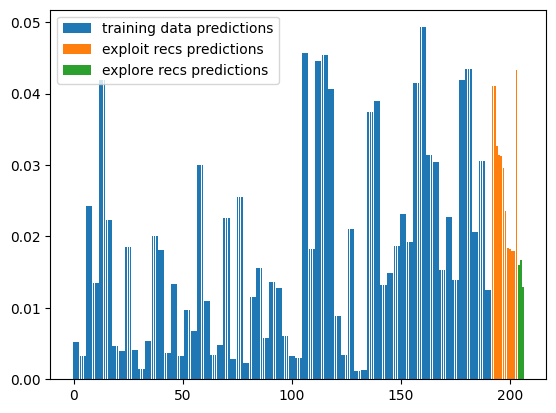

In [ ]:
fig, ax = plt.subplots()
ax.bar(range(art.X.shape[0]),art.predict(art.X).flatten(), label = 'training data predictions')
ax.bar(range(art.X.shape[0], art.X.shape[0]+user_params['n_instances_exploit']), np.array(df_recs_exploit['OD34yield_pred']).flatten(), label = 'exploit recs predictions')
ax.bar(range(art.X.shape[0]+user_params['n_instances_exploit'],art.X.shape[0]+user_params['n_instances_exploit']+user_params['n_instances_explor'])\
        , np.array(df_recs_explore['OD34yield_pred']).flatten(), label = 'explore recs predictions')
ax.legend()
plt.show()
fig.savefig(user_params['output_dir']+'/rec_bar_graph.png')

In [ ]:
df

Measurement Type,Line Name,OD340,MOPS[mM],Tricine[mM],H3BO3[mM],Glucose[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],Kan[g/l],OD340yield
0,C1_WA1_C1-R1,0.1664,40.0,4.0,0.003661,32.989243,0.144954,0.61429,0.01745,7.979403,0.270786,26.240883,0.000021,0.000706,0.000188,0.000546,0.000092,0.05,0.005044
1,C1_WA1_C1-R2,0.1707,40.0,4.0,0.003661,32.989243,0.144954,0.61429,0.01745,7.979403,0.270786,26.240883,0.000021,0.000706,0.000188,0.000546,0.000092,0.05,0.005174
2,C1_WA1_C1-R3,0.1535,40.0,4.0,0.003661,32.989243,0.144954,0.61429,0.01745,7.979403,0.270786,26.240883,0.000021,0.000706,0.000188,0.000546,0.000092,0.05,0.004653
3,C1_WA2_C2-R1,0.3910,40.0,4.0,0.001096,129.69516,0.215986,5.430301,0.070543,9.628863,0.396082,21.94981,0.000185,0.000054,0.000027,0.000771,0.000028,0.05,0.003015
4,C1_WA2_C2-R2,0.4007,40.0,4.0,0.001096,129.69516,0.215986,5.430301,0.070543,9.628863,0.396082,21.94981,0.000185,0.000054,0.000027,0.000771,0.000028,0.05,0.00309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,C4_WD7_F7-R2,0.4136,40.0,4.0,0.030974,13.112744,0.982282,2.220679,0.097841,7.25641,3.672026,461.816356,0.000114,0.000194,0.000544,0.005805,0.000759,0.05,0.031542
188,C4_WD7_F7-R3,0.4024,40.0,4.0,0.030974,13.112744,0.982282,2.220679,0.097841,7.25641,3.672026,461.816356,0.000114,0.000194,0.000544,0.005805,0.000759,0.05,0.030688
189,C4_WD8_F8-R1,0.2280,40.0,4.0,0.004383,18.009772,0.293764,1.437228,0.010266,8.593542,0.48597,46.323371,0.000028,0.000304,0.000102,0.00078,0.000098,0.05,0.01266
190,C4_WD8_F8-R2,0.2162,40.0,4.0,0.004383,18.009772,0.293764,1.437228,0.010266,8.593542,0.48597,46.323371,0.000028,0.000304,0.000102,0.00078,0.000098,0.05,0.012005


### Concatenate the recommendations

In [ ]:
df_target = pd.concat([df_recs_explore, df_recs_exploit]).reset_index()


In [ ]:
df_target

,index,H3BO3[mM],Glucose[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],OD34yield_pred,OD34yield_std_pred,Label
0,0,0.013782,42.795319,0.689979,5.890308,0.080204,8.534230,3.036435,490.645332,0.000141,0.002972,0.000079,0.003381,0.000836,0.015964,0.015964,explore
1,1,0.002196,46.303341,1.627894,0.419898,0.072132,8.598819,3.170558,428.803023,0.000243,0.002480,0.000943,0.005789,0.000796,0.016764,0.016764,explore
2,2,0.021027,38.736065,0.039389,1.447582,0.060419,11.495846,3.470097,234.071325,0.000257,0.001495,0.000815,0.007781,0.000855,0.012894,0.012894,explore
3,0,0.010362,3.042005,1.201076,4.945357,0.096946,7.701755,1.743529,318.415402,0.000233,0.002811,0.000980,0.006352,0.000713,0.041071,0.041071,exploit
4,1,0.035995,3.069360,1.910974,3.277694,0.065778,6.387180,4.389175,450.776426,0.000144,0.002921,0.000684,0.002559,0.000816,0.041017,0.041017,exploit
5,2,0.033823,9.997433,0.762536,3.097878,0.098168,10.274320,4.210017,388.836168,0.000210,0.001809,0.000651,0.007696,0.000473,0.032616,0.032616,exploit
6,3,0.017092,9.539904,2.723094,4.296239,0.074726,11.004123,4.440926,389.940107,0.000204,0.000854,0.000939,0.006288,0.000846,0.031417,0.031417,exploit
7,4,0.011778,11.184317,2.342212,2.450390,0.096537,9.495708,2.965366,478.221158,0.000079,0.002749,0.000731,0.000113,0.000946,0.031275,0.031275,exploit
8,5,0.009212,13.046526,2.471904,5.418282,0.095785,7.075683,3.484387,458.712533,0.000219,0.002644,0.000453,0.006622,0.000792,0.029630,0.029630,exploit
9,6,0.034275,13.208940,2.513104,5.323705,0.039940,8.128852,3.315675,378.872203,0.000143,0.002949,0.000724,0.002889,0.000973,0.023504,0.023504,exploit


In [ ]:
user_params['standard_media_file']

'../flaviolin yield data/standard_recipe_concentrations.csv'

In [ ]:
df_stand = pd.read_csv(user_params['standard_media_file']).set_index("Component")
df_stand = df_stand.rename(columns = {"Concentration":'Concentration[mM]'} )
df_stand

,Concentration[mM],Solubility
Component,,
MOPS[mM],40.00000,1700.00
Tricine[mM],4.00000,500.08
H3BO3[mM],0.00400,700.00
Glucose[mM],20.00000,5045.63
K2SO4[mM],0.29000,636.98
K2HPO4[mM],1.32000,8564.84
FeSO4[mM],0.01000,1645.73
NH4Cl[mM],9.52000,6543.28
MgCl2[mM],0.52000,569.27


In [ ]:
ub = 1.1
lb = 0.9
df_control = pd.DataFrame(columns=user_params['components'])

for component in user_params['components']:
    stand_conc = df_stand.loc[component]['Concentration[mM]']
    df_control.at['Control', component] = stand_conc*np.random.uniform(lb, ub)

df_control

,H3BO3[mM],Glucose[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM]
Control,0.003911,19.053726,0.308325,1.22719,0.010482,10.032627,0.488226,48.073026,0.00003,0.000304,0.000096,0.000735,0.000091


In [ ]:
for component in user_params['components'][:-1]:
     assert(all(df_control.at['Control', component] != control_lines[component]))

In [ ]:
control_predicted_mean, control_predicted_std = art.post_pred_stats(
            df_control.values
        )
df_control['OD340yield_pred'] = control_predicted_mean
df_control['OD340yield_std'] = control_predicted_std
df_control['Label'] = 'standard'

In [ ]:
df_control

,H3BO3[mM],Glucose[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],OD340yield_pred,OD340yield_std,Label
Control,0.003911,19.053726,0.308325,1.22719,0.010482,10.032627,0.488226,48.073026,0.00003,0.000304,0.000096,0.000735,0.000091,0.01291,0.003759,standard


### Save the training data

In [111]:
df_train = df[user_params['components']]
df_train['OD340'] = df['OD340']
df_train['OD340yield'] = df_train['Glucose[mM]']/df_train['OD340']

/tmp/ipykernel_3632/545099463.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['OD340'] = df['OD340']
/tmp/ipykernel_3632/545099463.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['OD340yield'] = df_train['Glucose[mM]']/df_train['OD340']


In [112]:
df_train

Measurement Type,H3BO3[mM],Glucose[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],OD340,OD340yield
0,0.003661,32.989243,0.144954,0.61429,0.01745,7.979403,0.270786,26.240883,0.000021,0.000706,0.000188,0.000546,0.000092,0.1664,198.252662
1,0.003661,32.989243,0.144954,0.61429,0.01745,7.979403,0.270786,26.240883,0.000021,0.000706,0.000188,0.000546,0.000092,0.1707,193.2586
2,0.003661,32.989243,0.144954,0.61429,0.01745,7.979403,0.270786,26.240883,0.000021,0.000706,0.000188,0.000546,0.000092,0.1535,214.913635
3,0.001096,129.69516,0.215986,5.430301,0.070543,9.628863,0.396082,21.94981,0.000185,0.000054,0.000027,0.000771,0.000028,0.3910,331.701176
4,0.001096,129.69516,0.215986,5.430301,0.070543,9.628863,0.396082,21.94981,0.000185,0.000054,0.000027,0.000771,0.000028,0.4007,323.671475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,0.030974,13.112744,0.982282,2.220679,0.097841,7.25641,3.672026,461.816356,0.000114,0.000194,0.000544,0.005805,0.000759,0.4136,31.703926
188,0.030974,13.112744,0.982282,2.220679,0.097841,7.25641,3.672026,461.816356,0.000114,0.000194,0.000544,0.005805,0.000759,0.4024,32.586342
189,0.004383,18.009772,0.293764,1.437228,0.010266,8.593542,0.48597,46.323371,0.000028,0.000304,0.000102,0.00078,0.000098,0.2280,78.990228
190,0.004383,18.009772,0.293764,1.437228,0.010266,8.593542,0.48597,46.323371,0.000028,0.000304,0.000102,0.00078,0.000098,0.2162,83.301443


In [126]:
train_predicted_mean, train_predicted_std = art.post_pred_stats(
            df_train[user_params['components']].values)
        
df_train['OD340yield'] = df_train['OD340']/df_train['Glucose[mM]']
df_train['OD340yield_pred'] = train_predicted_mean
df_train['OD340yield_std'] = train_predicted_std
df_train['OD340yield_cv_pred'] = art.model_prediction_cv_dfs[0]["Predictions"]["Ensemble Model"]
df_train['OD340yield_cv_std'] = art.model_prediction_cv_dfs[0]["Predictions StDev"]["Ensemble Model"]
df_train['Label'] = 'train'

control_lines = df[df['Line Name'].str.find('_F8') > 0]

df_train.loc[control_lines.index, 'Label'] = 'standard'

Measurement Type,H3BO3[mM],Glucose[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],OD340,OD340yield,OD340yield_pred,OD340yield_std,OD340yield_cv_pred,OD340yield_cv_std,Label
96,0.0004,66.750254,1.92039,6.42214,0.1,14.059542,0.052,497.923422,0.0003,0.003,0.001,0.008,0.00001,0.3358,0.005031,0.006098,0.003765,0.009982,0.003924,train
97,0.0004,66.750254,1.92039,6.42214,0.1,14.059542,0.052,497.923422,0.0003,0.003,0.001,0.008,0.00001,0.3408,0.005106,0.006098,0.003765,0.009982,0.003924,train
98,0.0004,66.750254,1.92039,6.42214,0.1,14.059542,0.052,497.923422,0.0003,0.003,0.001,0.008,0.00001,0.3575,0.005356,0.006098,0.003765,0.009982,0.003924,train
99,0.002521,103.935952,1.574595,5.00246,0.096235,13.352076,0.058269,496.72474,0.00028,0.002802,0.000924,0.005394,0.000255,0.2620,0.002521,0.003279,0.003760,0.004708,0.004036,train
100,0.002521,103.935952,1.574595,5.00246,0.096235,13.352076,0.058269,496.72474,0.00028,0.002802,0.000924,0.005394,0.000255,0.3022,0.002908,0.003279,0.003760,0.004708,0.004036,train
101,0.002521,103.935952,1.574595,5.00246,0.096235,13.352076,0.058269,496.72474,0.00028,0.002802,0.000924,0.005394,0.000255,0.3017,0.002903,0.003279,0.003760,0.004708,0.004036,train
102,0.01321,156.405637,1.429833,2.551329,0.093805,11.772126,0.526236,498.463992,0.00024,0.002971,0.000964,0.004349,0.000178,0.4213,0.002694,0.002911,0.003759,0.001654,0.004414,train
103,0.01321,156.405637,1.429833,2.551329,0.093805,11.772126,0.526236,498.463992,0.00024,0.002971,0.000964,0.004349,0.000178,0.4104,0.002624,0.002911,0.003759,0.001654,0.004414,train
104,0.01321,156.405637,1.429833,2.551329,0.093805,11.772126,0.526236,498.463992,0.00024,0.002971,0.000964,0.004349,0.000178,0.4175,0.002669,0.002911,0.003759,0.001654,0.004414,train
105,0.019815,2.438664,1.559669,1.496754,0.071106,9.64611,4.720353,499.592575,0.000179,0.000158,0.000338,0.005856,0.000919,0.1140,0.046747,0.045712,0.003760,0.036425,0.004427,train


In [128]:
file = f"{user_params['output_dir']}/train_pred.csv"
df_train.to_csv(file)


In [ ]:
df_target = pd.concat([df_target,df_control]).reset_index(drop=True)
df_target = df_target.loc[df_target.index.repeat(user_params['n_replicates'])]
df_target

In [ ]:
well_rows = 'ABCDEF'
well_columns = '12345678'
well_names = [f'{row}{column}'  for column in well_columns for row in well_rows]

df_target['Well'] = well_names
df_target = df_target.set_index(['Well'])
df_target.head()

In [147]:
file = f"{user_params['output_dir']}/target_concentrations.csv"
df_target.to_csv(file) 

In [148]:
file

'../flaviolin yield data/DBTL5/target_concentrations.csv'